# Find STAC Imagery to use using SAT-search

We will be using the SAT-search library to search for a library
https://github.com/sat-utils/sat-search

We can install it using: `pip install sat-search`

We will be accessing the Sentinel-2 L2A datasets. We can read the documentation on this particular data set here: https://roda.sentinel-hub.com/sentinel-s2-l2a/readme.html

## Requirements

- Python version
- Stac version
- OS

## Docker Container


**Objectives**

-  learn how to use Stac Search to search for and download imagery


Set-up: 


1. Ensure your configuration options include `AWS_NO__SIGN_REQUEST = YES`

 https://gdal.org/user/virtual_file_systems.html

 https://github.com/cogeotiff/rio-tiler/issues/19

 https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

 https://github.com/sentinel-hub/custom-scripts

In [88]:
import os
# Set environment
os.environ['AWS_NO_SIGN_REQUEST']='YES'

First we need to use the `Search` function from satsearch. Search takes two arguments `self` and `url`. We can pass in a url that we know and assign it to `url`. The other option is to set an environment variable with the url we want to access by default and Search will automatically know to use the environment variable. 

Below we are using the `inspect` library to view the arguments Search accepts. You can usually also find this information in documentation for a specific package.

In [10]:
# Import search from satseaarch
from satsearch import Search
#import the inspect library
import inspect

#Insepect the search function's arguments 
inspect.getfullargspec(Search).args


['self', 'url']

Here we can see the `Search` function references `self` and `url`. 

We are going to use the url: `'https://earth-search.aws.element84.com/v0` which contains Sentinel data. There are a lot of ways to structure your query for the search. Below are a few different options for searching.  You can search for imagery that is within a specific bounding box, between dates, specific cloud coverage and many other attributes.



In [11]:
from satsearch import Search

# search a given url for the bounding box 
search = Search('https://earth-search.aws.element84.com/v0',bbox=[-110, 39.5, -105, 40.5])

print('bbox search: %s items' % search.found())

# Search a given url for specific dates and times
search = Search('https://earth-search.aws.element84.com/v0',datetime='2018-02-12T00:00:00Z/2018-03-18T12:31:12Z')
print('time search: %s items' % search.found())

# Search with a specific cloud cover

search = Search('https://earth-search.aws.element84.com/v0',query={'eo:cloud_cover': {'lt': 10}})
print('cloud_cover search: %s items' % search.found())

bbox search: 24614 items
time search: 714897 items
cloud_cover search: 15432726 items


Once we are comfortable with our query we can put all these individual lines into one query and search.


In [12]:
search = Search('https://earth-search.aws.element84.com/v0',
               bbox=[-110, 39.5, -105, 40.5],
               datetime='2018-02-01/2018-02-04',
               property=["eo:cloud_cover<5"])
print('%s items' % search.found())

items = search.items()
print('%s items' % len(items))
print('%s collections' % len(items._collections))
print(items._collections)

for item in items:
    print(item)

36 items
36 items
3 collections
[sentinel-s2-l1c, sentinel-s2-l2a-cogs, sentinel-s2-l2a]
S2B_13SCD_20180204_0_L1C
S2B_12TXK_20180204_0_L1C
S2B_13TCE_20180204_0_L1C
S2B_12TYK_20180204_0_L1C
S2B_12TWK_20180204_0_L1C
S2B_13TBE_20180204_0_L1C
S2B_13TBE_20180204_0_L2A
S2B_12TYK_20180204_0_L2A
S2B_13SCD_20180204_0_L2A
S2B_12TWK_20180204_0_L2A
S2B_13TCE_20180204_0_L2A
S2B_12TXK_20180204_0_L2A
S2B_13TBE_20180204_0_L2A
S2B_12TYK_20180204_0_L2A
S2B_13SCD_20180204_0_L2A
S2B_12TWK_20180204_0_L2A
S2B_13TCE_20180204_0_L2A
S2B_12TXK_20180204_0_L2A
S2A_12TWK_20180202_0_L1C
S2A_12TXK_20180202_0_L1C
S2A_12SWJ_20180202_0_L1C
S2A_12SXJ_20180202_0_L1C
S2A_12TXK_20180202_0_L2A
S2A_12SXJ_20180202_0_L2A
S2A_12SWJ_20180202_0_L2A
S2A_12TWK_20180202_0_L2A
S2A_12TXK_20180202_0_L2A
S2A_12SXJ_20180202_0_L2A
S2A_12SWJ_20180202_0_L2A
S2A_12TWK_20180202_0_L2A
S2B_13SED_20180201_0_L1C
S2B_13SDD_20180201_0_L1C
S2B_13SED_20180201_0_L2A
S2B_13SDD_20180201_0_L2A
S2B_13SDD_20180201_0_L2A
S2B_13SED_20180201_0_L2A


In [13]:
items = search.items(limit=2)
print(items.summary())

There are more items found (36) than the limit (2) provided.


Items (36):
date                      id                        
2018-02-04                S2B_13SCD_20180204_0_L1C  
2018-02-04                S2B_13TCE_20180204_0_L1C  
2018-02-04                S2B_12TXK_20180204_0_L1C  
2018-02-04                S2B_12TYK_20180204_0_L1C  
2018-02-04                S2B_12TWK_20180204_0_L1C  
2018-02-04                S2B_13TBE_20180204_0_L1C  
2018-02-04                S2B_13TBE_20180204_0_L2A  
2018-02-04                S2B_12TYK_20180204_0_L2A  
2018-02-04                S2B_13SCD_20180204_0_L2A  
2018-02-04                S2B_12TWK_20180204_0_L2A  
2018-02-04                S2B_13TCE_20180204_0_L2A  
2018-02-04                S2B_12TXK_20180204_0_L2A  
2018-02-04                S2B_13TBE_20180204_0_L2A  
2018-02-04                S2B_12TYK_20180204_0_L2A  
2018-02-04                S2B_13SCD_20180204_0_L2A  
2018-02-04                S2B_12TWK_20180204_0_L2A  
2018-02-04                S2B_13TCE_20180204_0_L2A  
2018-02-04                S2B_12TX

In [14]:
#Experiment with a different bounding box here
# 
#Extent Algonquin 
#-79.3419701943353743,45.1246460780530541 : -77.1836347675999974,46.3029420497143249


from satstac import ItemCollection
#45.909954232902145, -78.18165063404649
search = Search.search(url = 'https://earth-search.aws.element84.com/v0',
               bbox=[ -78.1816,45.9099, -79.18, 47.9099,],
               datetime='2018-02-01/2018-02-10',
               query=["eo:cloud_cover<25"],
               collections=['sentinel-s2-l2a'])
items = search.items()
print(items.summary())

#Save the results to a json file
items.save('test.json')

#open the saved results 
items2 = ItemCollection.open('test.json')

print(items2.summary(['date', 'id', 'eo:cloud_cover']))

Items (2):
date                      id                        
2018-02-09                S2A_17TPN_20180209_0_L2A  
2018-02-06                S2A_17TPM_20180206_0_L2A  

Items (2):
date                      id                        eo:cloud_cover            
2018-02-09                S2A_17TPN_20180209_0_L2A  22.71                     
2018-02-06                S2A_17TPM_20180206_0_L2A  22.67                     



In [14]:
# download a specific asset from all items and put in a directory by date in 'downloads'
filenames = items.download('metadata', filename_template='downloads/${date}/${id}')
print(filenames)

['downloads/2018-02-07/S2B_12TXK_20180207_0_L2A_metadata.xml', 'downloads/2018-02-07/S2B_12TWK_20180207_0_L2A_metadata.xml', 'downloads/2018-02-07/S2B_12SWJ_20180207_0_L2A_metadata.xml', 'downloads/2018-02-07/S2B_12SXJ_20180207_0_L2A_metadata.xml', 'downloads/2018-02-02/S2A_12TXK_20180202_0_L2A_metadata.xml', 'downloads/2018-02-02/S2A_12SXJ_20180202_0_L2A_metadata.xml', 'downloads/2018-02-02/S2A_12SWJ_20180202_0_L2A_metadata.xml']


In [30]:
#list assets by common name
#print(item.assets_by_common_name)

#List the item keys
print(item.assets.keys())



dict_keys(['thumbnail', 'overview', 'info', 'metadata', 'visual', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'AOT', 'WVP', 'SCL'])


In [36]:
for x in item.assets.values():
    print (x['title'])

Thumbnail
True color image
Original JSON metadata
Original XML metadata
True color image
Band 1 (coastal)
Band 2 (blue)
Band 3 (green)
Band 4 (red)
Band 5
Band 6
Band 7
Band 8 (nir)
Band 8A
Band 9
Band 11 (swir16)
Band 12 (swir22)
Aerosol Optical Thickness (AOT)
Water Vapour (WVP)
Scene Classification Map (SCL)


In [38]:
# Create empty list
download_urls = []

# for each item within our item list get the values of the assets

for x in item.assets.values():
    #save url to list
    download_urls.append(x['href'])
    # print the urls
    print(x['href'])

https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/13/S/ED/2018/2/1/0/preview.jpg
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/L2A_PVI.tif
https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/13/S/ED/2018/2/1/0/tileInfo.json
https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/13/S/ED/2018/2/1/0/metadata.xml
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/TCI.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/B01.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/B02.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/B03.tif
https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/B04.tif
https://sentinel-cogs.s3.us-west-2.a

## Downloading the list of images

Let's say that you want to download all the images you have found to your local hard drive. We can take the list from above and create a for loop to download from the list.
If we want to work locally, load these images into QGIS we can.

In [40]:
import os
import urllib

def get_filename(url):
    """
    Parses filename from given url
    """
    if url.find('/'):
        return url.rsplit('/', 1)[1]

# Filepath to save to
outdir = "/Users/laurenyee/Desktop/Projects/STAC"

# Create folder if it does no exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Download files
for url in download_urls:
    # Parse filename
    fname = get_filename(url)
    outfp = os.path.join(outdir, fname)
    # Download the file if it does not exist already
    if not os.path.exists(outfp):
        print("Downloading", fname)
        r = urllib.request.urlretrieve(url, outfp)

## Another Approach 

Another approach is to use the common name to find the particular asset you want.


In [96]:
for item in items:
    print(item)
    print(item.properties)
    

S2A_17TPN_20180209_0_L2A
{'datetime': '2018-02-09T16:24:22Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'gsd': 10, 'data_coverage': 69.59, 'view:off_nadir': 0, 'eo:cloud_cover': 22.71, 'proj:epsg': 32617, 'sentinel:latitude_band': 'T', 'sentinel:grid_square': 'PN', 'sentinel:sequence': '0', 'sentinel:product_id': 'S2A_MSIL2A_20180209T162421_N0001_R040_T17TPN_20200326T190020', 'created': '2020-08-30T09:05:24.793Z', 'updated': '2020-08-30T09:05:24.793Z', 'sentinel:valid_cloud_cover': True, 'sentinel:utm_zone': 17, 'sentinel:data_coverage': 69.59}


TypeError: 'method' object is not subscriptable

In [81]:
item.asset('red')

{'title': 'Band 4 (red)',
 'type': 'image/jp2',
 'href': 's3://sentinel-s2-l2a/tiles/17/T/PM/2018/2/6/0/R10m/B04.jp2',
 'roles': ['data'],
 'eo:bands': [{'full_width_half_max': 0.038,
   'center_wavelength': 0.6645,
   'name': 'B04',
   'common_name': 'red'}],
 'gsd': 10}

In [98]:
for x in item.assets.values():
    print(x['href'])

example_url = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/B03.tif'   

https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/17/T/PN/2018/2/9/0/preview.jpg
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/qi/L2A_PVI.jp2
https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/tileInfo.json
https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/metadata.xml
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R10m/TCI.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R20m/TCI.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R60m/TCI.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R60m/B01.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R10m/B02.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R10m/B03.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R10m/B04.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R20m/B05.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R20m/B06.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R20m/B07.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/2018/2/9/0/R10m/B08.jp2
s3://sentinel-s2-l2a/tiles/17/T/PN/201

In [90]:
file_url = item.asset('red')['href']
file_url



{'title': 'Band 4 (red)',
 'type': 'image/jp2',
 'href': 's3://sentinel-s2-l2a/tiles/17/T/PM/2018/2/6/0/R10m/B04.jp2',
 'roles': ['data'],
 'eo:bands': [{'full_width_half_max': 0.038,
   'center_wavelength': 0.6645,
   'name': 'B04',
   'common_name': 'red'}],
 'gsd': 10}

In [83]:
print(item.datetime)
print(item.date)

2018-02-06 16:14:34+00:00
2018-02-06


In [84]:
for key in item.properties:
    print('%s: %s' % (key, item.properties[key]))

datetime: 2018-02-06T16:14:34Z
platform: sentinel-2a
constellation: sentinel-2
instruments: ['msi']
gsd: 10
data_coverage: 100
view:off_nadir: 0
eo:cloud_cover: 22.67
proj:epsg: 32617
sentinel:latitude_band: T
sentinel:grid_square: PM
sentinel:sequence: 0
sentinel:product_id: S2A_MSIL2A_20180206T161431_N0001_R140_T17TPM_20200326T160140
created: 2020-08-30T09:04:24.542Z
updated: 2020-08-30T09:04:24.542Z
sentinel:valid_cloud_cover: True
sentinel:utm_zone: 17
sentinel:data_coverage: 100


In [99]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

with rasterio.open(example_url) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 10980, 'height': 10980, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 499980.0,
       0.0, -10.0, 4400040.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


`rasterio.open()` functions like the python standard library function open for opening files. The block of code within the with `...` as statement is executed once the file is opened, and the file is closed when the context manager exits. This means that we don’t have to manually close the raster file, as the context manager handles that for us.

Instead of a local file path, rasterio knows how to read URLs too, so we just passed the link to the file on AWS

`src.profile` is a collection of metadata for the file.

Decimation factor= 16
array type:  <class 'numpy.ndarray'>
[[ 8788  9505  9151 ...     0     0     0]
 [ 9574  9768  9216 ...     0     0     0]
 [10533  9891  9254 ...     0     0     0]
 ...
 [ 2566  1945   694 ...     0     0     0]
 [ 1823  2106  1327 ...     0     0     0]
 [  590  1641  2403 ...     0     0     0]]


Text(0, 0.5, 'Row #')

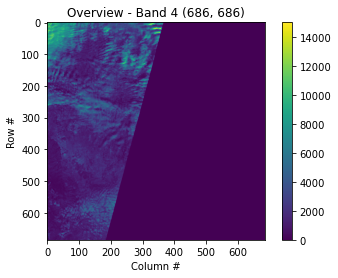

In [100]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(example_url) as src:
   oviews = src.overviews(1) # list of overviews from biggest to smallest
   oview = oviews[-1] # let's look at the smallest thumbnail
   print('Decimation factor= {}'.format(oview))
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

print('array type: ',type(thumbnail))
print(thumbnail)

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Pixels outside the imaged area are clearly set to “0”. The colormap could be improved if we change the out of bounds area to NaN. To do this we have to convert the datatype from uint16 to float32 (so be aware the array with NaNs will take 2x the storage space)

Decimation factor= 16


Text(0, 0.5, 'Row #')

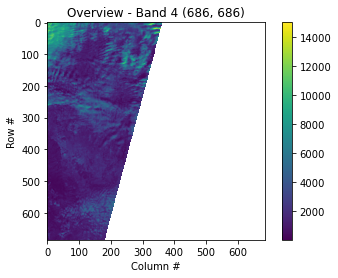

In [101]:
with rasterio.open(example_url) as src:
    oviews = src.overviews(1)
    oview = oviews[-1]
    print('Decimation factor= {}'.format(oview))
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

plt.imshow(thumbnail)
plt.colorbar()
plt.title('Overview - Band 4 {}'.format(thumbnail.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

### Calculate NDVI

NDVI is a simple indicator that can be calculated by obtaining the red and near IR bands of a satellite image. The difference in values between these two sensors can be used to evaluate healthy vegetation or 'greenness'. 

In [104]:
# Create a function called calc_ndvi to calculate NDVI
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

Let's find the url of the red and NIR bands and assign them to a red and nir variable respectively

In [102]:
redband = example_url
nirband = 'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/13/S/ED/2018/2/S2B_13SED_20180201_0_L2A/B08.tif'


with rasterio.open(redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

with rasterio.open(nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))



Decimation factor= 4


Now we can use our function and assign it to `ndvi` and plot the results

<ipython-input-104-7b0b0e77a716>:6: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (nir - red) / (nir + red)


Text(0, 0.5, 'Row #')

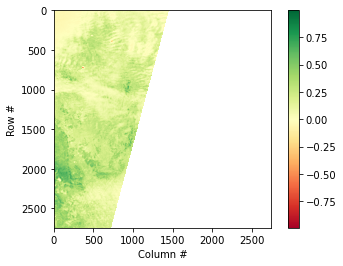

In [106]:
ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
#plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

## Save Result Locally

So far we just read in the data into python from a url. If we want to save our results locally we can.

In [107]:
localname = 'NDVI_calc.tif'
#open the NIR band and copy the meta data
with rasterio.open(nirband) as src:
    profile = src.profile.copy()
#update the existing meta data
    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

## Resources

This tutorial derived content from many different sources such as:
